# Publication Figures Generation

This notebook creates publication-ready figures for the CNN ensemble model analysis.

# Setup and Imports

In [1]:
! pip install matplotlib numpy pandas torch seaborn scikit-learn tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

import src.data as data
import src.models as models
import src.training as training

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

In [ ]:
# Define data paths
TRAINING_DATA_PATH = "data/esm2_15b_embeddings_and_meta.csv"
OUTPUTS_DIR = Path("outputs")
FIGURES_DIR = Path("figures")
MODEL_PATH = OUTPUTS_DIR / "cnn_ensemble_model.pth"
PREDICTIONS_PATH = OUTPUTS_DIR / "all_sequences_predictions.csv"

# Figure output paths
FIG1_PATH = FIGURES_DIR / 'model_performance_vs_hamming_distance.svg'
FIG2_PATH = FIGURES_DIR / 'mean_brightness_vs_hamming_distance.svg'
FIG3_PATH = FIGURES_DIR / 'brightness_histogram_with_prediction_regions.svg'
FIG3_ALT_PATH = FIGURES_DIR / 'brightness_histogram.svg'

# Load Data and Model

In [5]:
# Load training data
df = pd.read_csv(TRAINING_DATA_PATH)
print(f"Loaded training data: {len(df)} sequences from {TRAINING_DATA_PATH}")

# Add number of mutations column if not present
if 'num_mutations' not in df.columns:
    num_mutations = []
    for idx, row in df.iterrows():
        if pd.isna(row.mutations) or row.mutations == '':
            num_mutations.append(0)
        else:
            num_mutations.append(len(row.mutations.split(":")))
    df["num_mutations"] = num_mutations
    
print(f"Hamming distance range: {df['num_mutations'].min()} to {df['num_mutations'].max()}")

Loaded training data: 31565 sequences from mount/data/esm2_15b_embeddings_and_meta.csv
Hamming distance range: 1 to 14


In [6]:
# Load trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.Ensemble().to(device)

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Trained model not found at {MODEL_PATH}. Please run 01_train_model.ipynb first.")

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"Loaded trained model from {MODEL_PATH}")

Loaded trained model from mount/outputs/cnn_ensemble_model.pth


In [7]:
results_df = pd.read_csv(PREDICTIONS_PATH)
print(f"Loaded predictions for {len(results_df)} sequences from {PREDICTIONS_PATH}")
print(f"Score range: {results_df['predicted_score'].min():.3f} to {results_df['predicted_score'].max():.3f}")

Loaded predictions for 1000 sequences from mount/outputs/all_sequences_predictions.csv
Score range: 1.193 to 3.886


In [8]:
# Create data holder for model evaluation
data_holder = data.ESMDataHolder(df)
print("Created data holder for model evaluation")

Created data holder for model evaluation


# Create Figures Directory

In [9]:
# Create figures directory
FIGURES_DIR.mkdir(exist_ok=True)
print(f"Created figures directory: {FIGURES_DIR}")

Created figures directory: mount/figures


# Figure 1: Model Performance vs Hamming Distance

In [10]:
def evaluate_model_at_hamming_distance(model, data_holder, distance):
    """Evaluate model R² score at a specific Hamming distance."""
    filtered_data = data_holder.for_cut_offs(min_distance=distance, max_distance=distance)
    loader = filtered_data.loader_all_data()
    return training.r2_score_for_model_and_loader(model, loader)

# Calculate R² scores for each Hamming distance
hamming_distances = range(df['num_mutations'].min(), min(11, df['num_mutations'].max() + 1))
r2_scores = []

print("Evaluating model performance at different Hamming distances...")
for dist in hamming_distances:
    r2 = evaluate_model_at_hamming_distance(model, data_holder, dist)
    r2_scores.append(r2)
    print(f"Hamming distance {dist}: R² = {r2:.4f}")

print(f"Completed evaluation for distances {list(hamming_distances)}")

Evaluating model performance at different Hamming distances...
Hamming distance 1: R² = 0.8323
Hamming distance 2: R² = 0.8433
Hamming distance 3: R² = 0.8609
Hamming distance 4: R² = 0.8567
Hamming distance 5: R² = 0.8377
Hamming distance 6: R² = 0.7690
Hamming distance 7: R² = 0.7696
Hamming distance 8: R² = 0.5930
Hamming distance 9: R² = 0.2567
Hamming distance 10: R² = 0.0076
Completed evaluation for distances [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


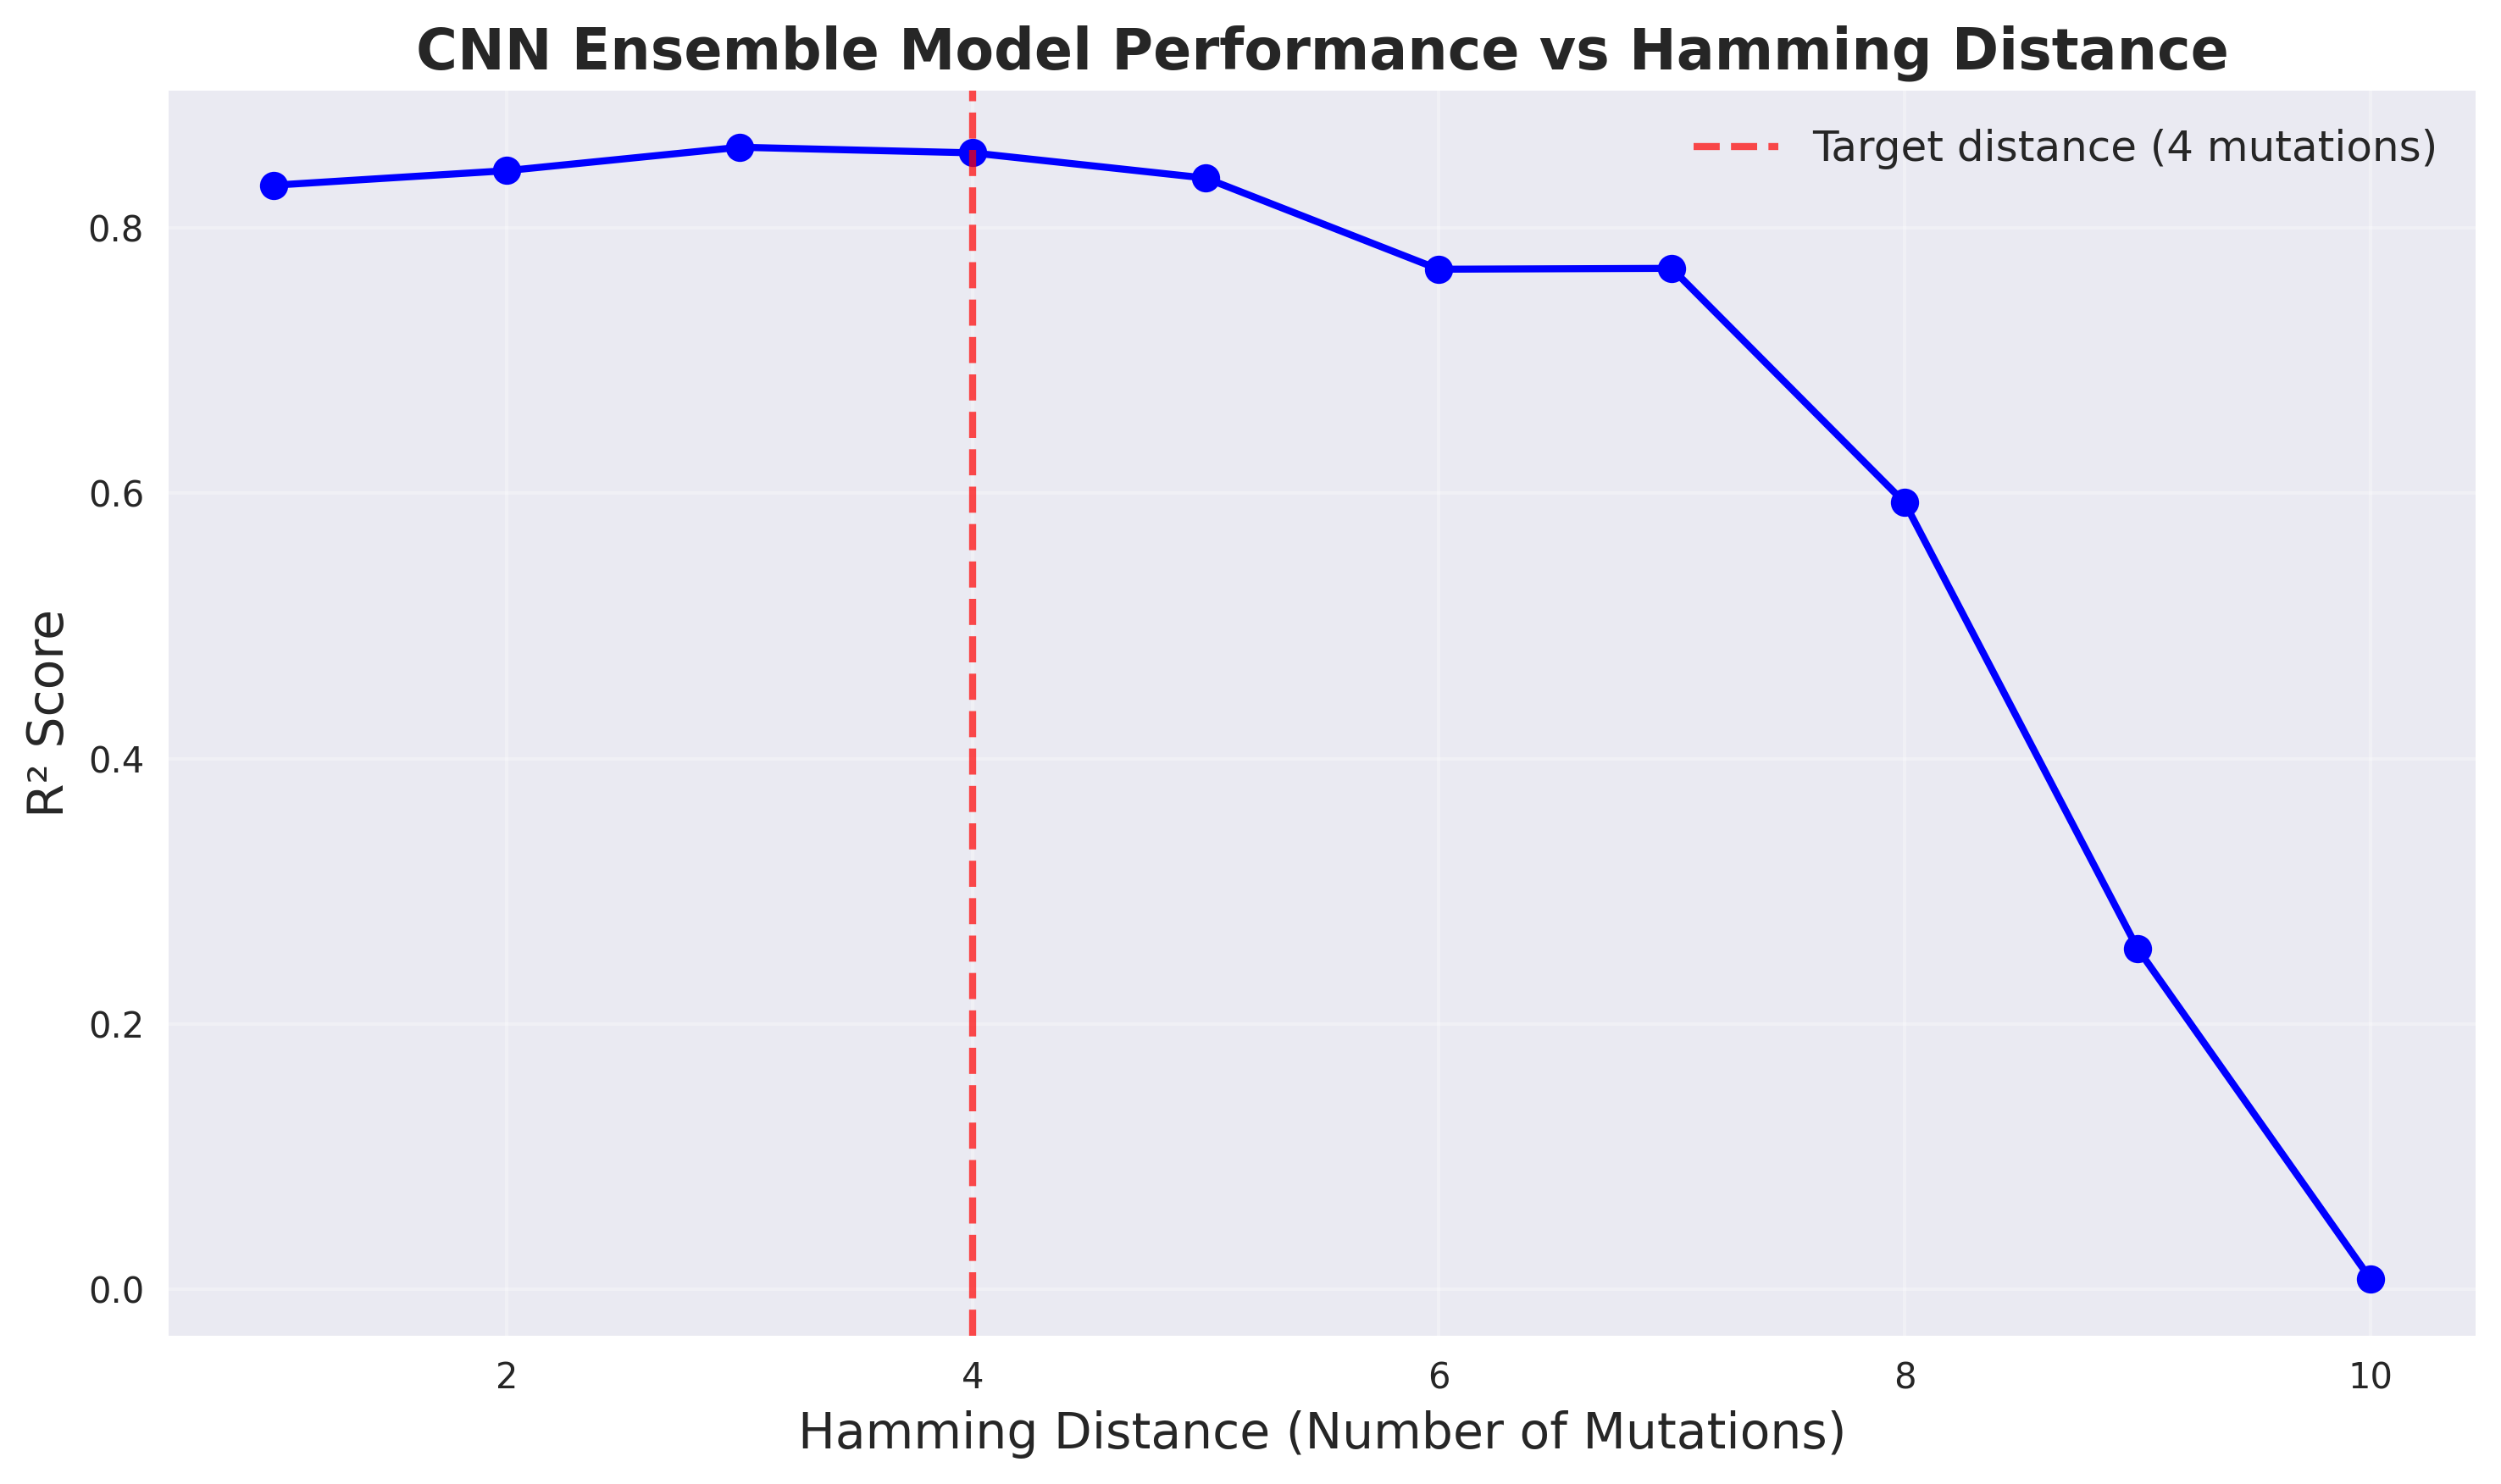

Figure 1 saved to: mount/figures/model_performance_vs_hamming_distance.svg


In [11]:
# Create Figure 1: Model Performance vs Hamming Distance
plt.figure(figsize=(10, 6))
plt.plot(hamming_distances, r2_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Target distance (4 mutations)')
plt.xlabel('Hamming Distance (Number of Mutations)', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.title('CNN Ensemble Model Performance vs Hamming Distance', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig(FIG1_PATH, format='svg', bbox_inches='tight', dpi=300)
plt.show()

print(f"Figure 1 saved to: {FIG1_PATH}")

# Figure 2: Mean Brightness vs Hamming Distance

In [12]:
# Calculate mean brightness and standard error by hamming distance
hamming_stats = df.groupby('num_mutations')['score'].agg(['mean', 'sem', 'count']).reset_index()
print("Brightness statistics by Hamming Distance:")
print(hamming_stats)

Brightness statistics by Hamming Distance:
    num_mutations      mean       sem  count
0               1  3.441347  0.024011    627
1               2  3.361484  0.007702   7545
2               3  3.029504  0.010617   7428
3               4  2.576014  0.013804   5653
4               5  2.117491  0.015143   4241
5               6  1.823938  0.015745   2716
6               7  1.587827  0.014190   1638
7               8  1.511652  0.014370    921
8               9  1.438674  0.014317    420
9              10  1.432997  0.013639    230
10             11  1.399727  0.013982     98
11             12  1.487535  0.077440     29
12             13  1.349624  0.021645     16
13             14  1.414781  0.113851      3


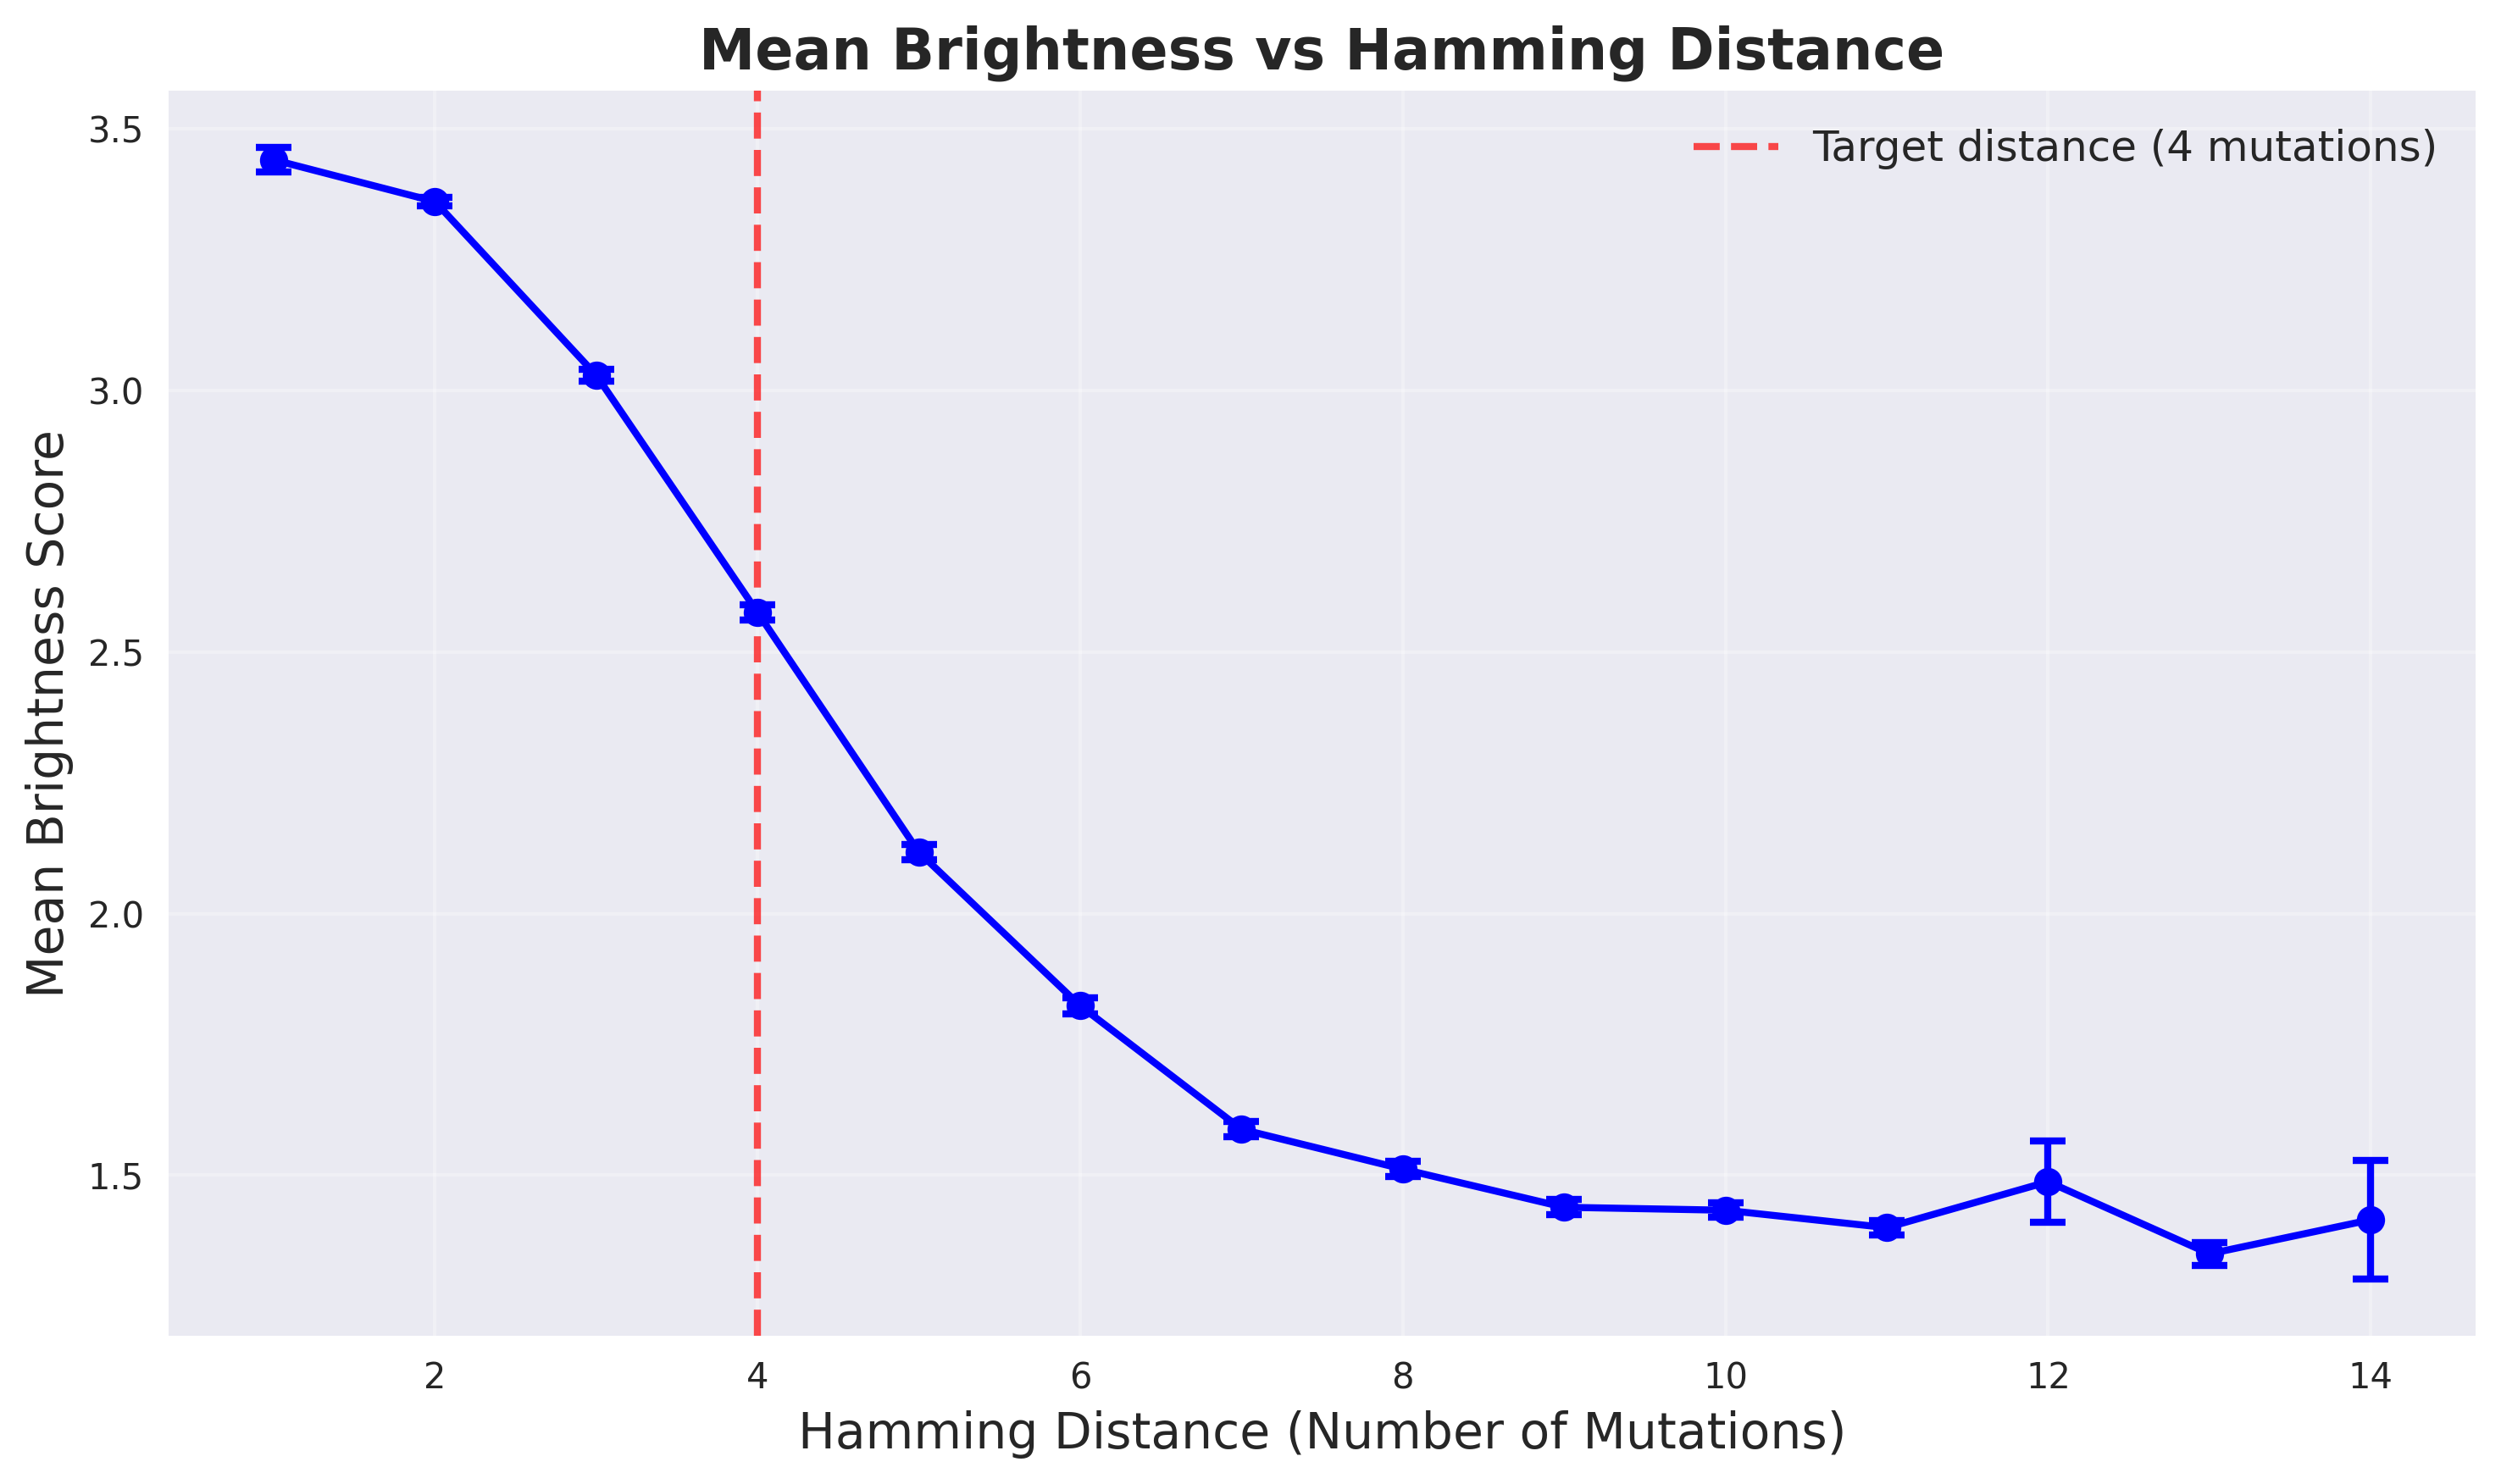

Figure 2 saved to: mount/figures/mean_brightness_vs_hamming_distance.svg

Summary statistics by Hamming Distance:
Distance   Mean       SEM        Count     
------------------------------------------
1.0        3.441      0.024      627.0     
2.0        3.361      0.008      7545.0    
3.0        3.030      0.011      7428.0    
4.0        2.576      0.014      5653.0    
5.0        2.117      0.015      4241.0    
6.0        1.824      0.016      2716.0    
7.0        1.588      0.014      1638.0    
8.0        1.512      0.014      921.0     
9.0        1.439      0.014      420.0     
10.0       1.433      0.014      230.0     
11.0       1.400      0.014      98.0      
12.0       1.488      0.077      29.0      
13.0       1.350      0.022      16.0      
14.0       1.415      0.114      3.0       


In [13]:
# Create Figure 2: Mean Brightness vs Hamming Distance with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(hamming_stats['num_mutations'], hamming_stats['mean'], 
             yerr=hamming_stats['sem'], fmt='bo-', capsize=5, capthick=2, 
             linewidth=2, markersize=8)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Target distance (4 mutations)')
plt.xlabel('Hamming Distance (Number of Mutations)', fontsize=14)
plt.ylabel('Mean Brightness Score', fontsize=14)
plt.title('Mean Brightness vs Hamming Distance', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig(FIG2_PATH, format='svg', bbox_inches='tight', dpi=300)
plt.show()

print(f"Figure 2 saved to: {FIG2_PATH}")

# Print summary statistics
print("\nSummary statistics by Hamming Distance:")
print(f"{'Distance':<10} {'Mean':<10} {'SEM':<10} {'Count':<10}")
print("-" * 42)
for _, row in hamming_stats.iterrows():
    print(f"{row['num_mutations']:<10} {row['mean']:<10.3f} {row['sem']:<10.3f} {row['count']:<10}")

# Figure 3: Brightness Histogram with Prediction Regions

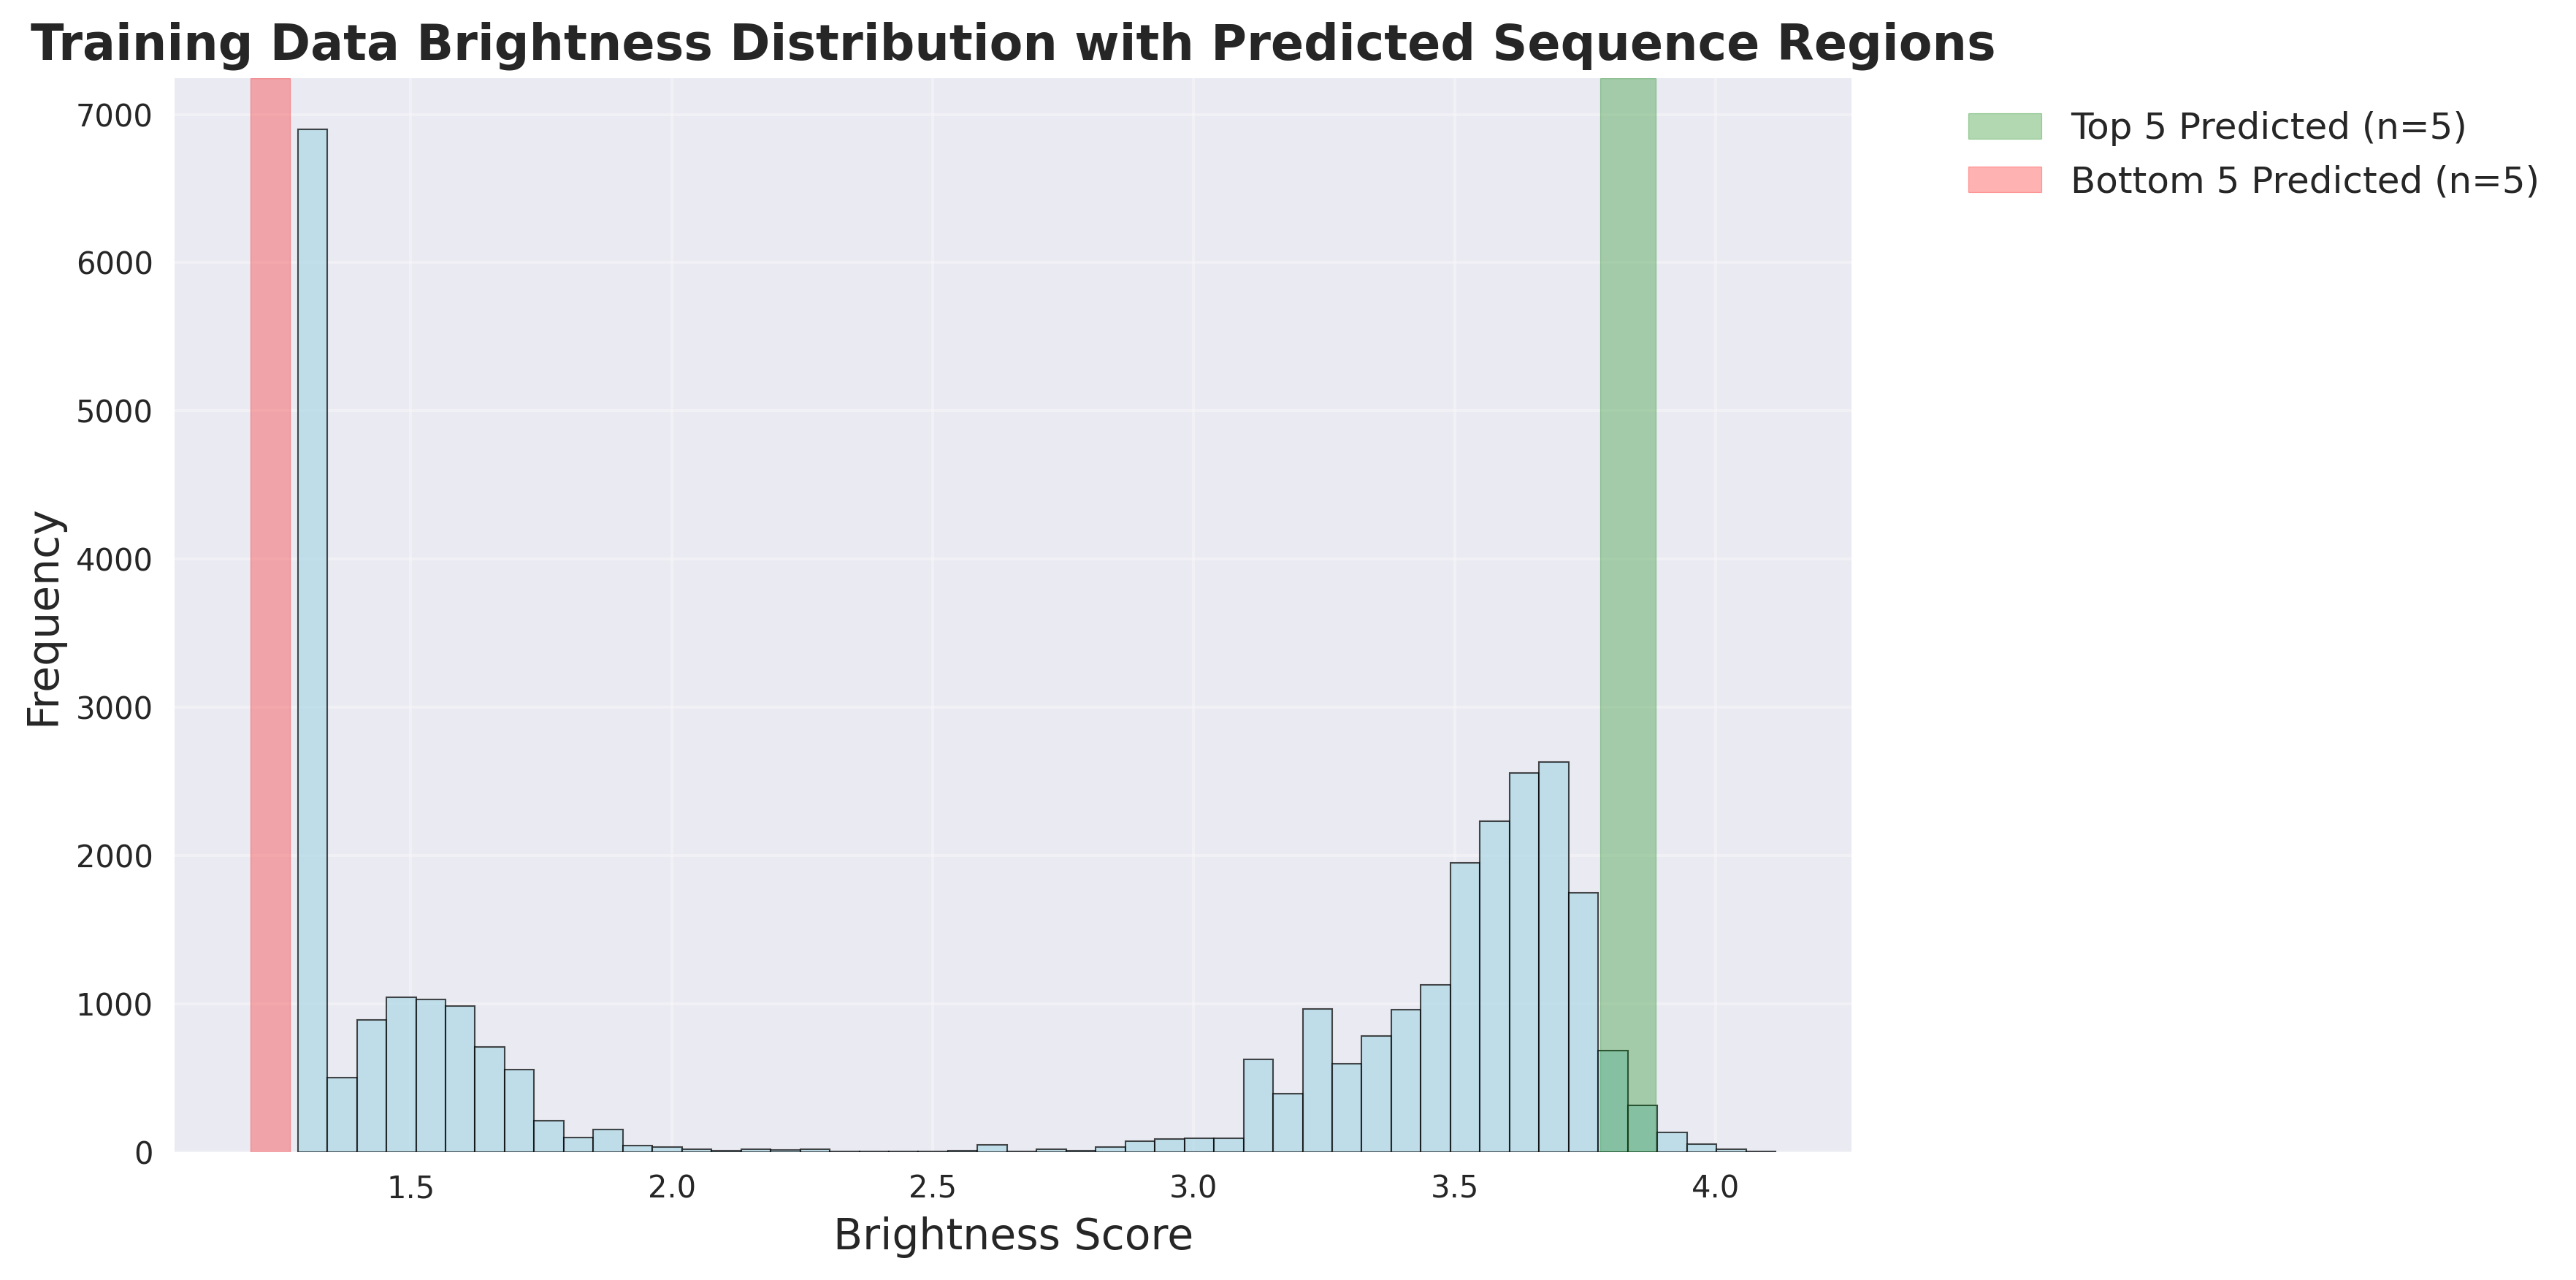

Figure 3 saved to: mount/figures/brightness_histogram_with_prediction_regions.svg

Prediction Region Analysis:
Full dataset sequences: 31565
Sequences in top 5 predicted region: 892 (2.8%)
Sequences in bottom 5 predicted region: 0 (0.0%)


In [14]:
# Create Figure 3: Brightness histogram with shaded regions for predictions
# Get top 5 and bottom 5 predicted sequences
top_5_scores = results_df.head(5)['predicted_score'].values
bottom_5_scores = results_df.tail(5)['predicted_score'].values

# Create histogram of all brightness values from main dataset
plt.figure(figsize=(12, 6))
plt.hist(df['score'], bins=50, alpha=0.7, color='lightblue', edgecolor='black', linewidth=0.5)

# Add shaded regions for top 5 and bottom 5 predicted sequences
plt.axvspan(top_5_scores.min(), top_5_scores.max(), alpha=0.3, color='green', 
            label=f'Top 5 Predicted (n={len(top_5_scores)})')
plt.axvspan(bottom_5_scores.min(), bottom_5_scores.max(), alpha=0.3, color='red', 
            label=f'Bottom 5 Predicted (n={len(bottom_5_scores)})')

# Styling and labels
plt.xlabel('Brightness Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Training Data Brightness Distribution with Predicted Sequence Regions', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig(FIG3_PATH, format='svg', bbox_inches='tight', dpi=300)
plt.show()

print(f"Figure 3 saved to: {FIG3_PATH}")

# Summary statistics
full_dataset_count = len(df)
top_region_count = len(df[(df['score'] >= top_5_scores.min()) & (df['score'] <= top_5_scores.max())])
bottom_region_count = len(df[(df['score'] >= bottom_5_scores.min()) & (df['score'] <= bottom_5_scores.max())])

print(f"\nPrediction Region Analysis:")
print(f"Full dataset sequences: {full_dataset_count}")
print(f"Sequences in top 5 predicted region: {top_region_count} ({top_region_count/full_dataset_count*100:.1f}%)")
print(f"Sequences in bottom 5 predicted region: {bottom_region_count} ({bottom_region_count/full_dataset_count*100:.1f}%)")

# Summary

In [15]:
# Create summary of all figures and statistics
print("=" * 60)
print("PUBLICATION FIGURES SUMMARY")
print("=" * 60)

print(f"\nFigures saved to directory: {FIGURES_DIR}")
print("\nGenerated figures:")
for i, fig_file in enumerate(sorted(FIGURES_DIR.glob("*.svg")), 1):
    print(f"  {i}. {fig_file.name}")

print(f"\nModel Performance Summary:")
print(f"  - Best R² score: {max(r2_scores):.4f} at distance {hamming_distances[np.argmax(r2_scores)]}")
print(f"  - R² at target distance (4 mutations): {r2_scores[list(hamming_distances).index(4)] if 4 in hamming_distances else 'N/A'}")

print(f"\nPrediction Summary:")
print(f"  - Total sequences predicted: {len(results_df)}")
print(f"  - Score range: {results_df['predicted_score'].min():.3f} to {results_df['predicted_score'].max():.3f}")
print(f"  - Mean predicted score: {results_df['predicted_score'].mean():.3f} ± {results_df['predicted_score'].std():.3f}")

print(f"\nTraining Data Summary:")
print(f"  - Total training sequences: {len(df)}")
print(f"  - Score range: {df['score'].min():.3f} to {df['score'].max():.3f}")
print(f"  - Mean training score: {df['score'].mean():.3f} ± {df['score'].std():.3f}")
print(f"  - Hamming distance range: {df['num_mutations'].min()} to {df['num_mutations'].max()}")

print("\n" + "=" * 60)
print("All publication figures have been successfully generated!")
print("=" * 60)

PUBLICATION FIGURES SUMMARY

Figures saved to directory: mount/figures

Generated figures:
  1. brightness_histogram_with_prediction_regions.svg
  2. mean_brightness_vs_hamming_distance.svg
  3. model_performance_vs_hamming_distance.svg

Model Performance Summary:
  - Best R² score: 0.8609 at distance 3
  - R² at target distance (4 mutations): 0.856685221195221

Prediction Summary:
  - Total sequences predicted: 1000
  - Score range: 1.193 to 3.886
  - Mean predicted score: 1.852 ± 0.662

Training Data Summary:
  - Total training sequences: 31565
  - Score range: 1.283 to 4.115
  - Mean training score: 2.650 ± 1.056
  - Hamming distance range: 1 to 14

All publication figures have been successfully generated!


# Publication Figures Complete

All publication-ready figures have been generated and saved to the `figures/` directory as high-resolution SVG files.

## Generated Figures:
1. **Model Performance vs Hamming Distance** - Shows how model R² varies with sequence distance
2. **Mean Brightness vs Hamming Distance** - Shows the relationship between mutations and brightness
3. **Brightness Histogram with Prediction Regions** - Shows where predicted sequences fall in the brightness distribution

These figures are ready for publication and can be easily imported into manuscripts or presentations.